Research Paper: https://arxiv.org/abs/1904.05068

2019 paper

Dataset: CIFAR 100

"Relational Knowledge Distillation" introduces a novel perspective to knowledge distillation by emphasizing the importance of pairwise relationships in the feature space and using them to distill knowledge from teacher to student models.

Code Link: https://github.com/lenscloth/RKD




In [1]:
!pip install torch torchvision --quiet

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# Load Data - CIFAR10
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]


train_transform = transforms.Compose([transforms.Pad(4),
                                      transforms.RandomCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Testing 1

In [53]:
teacher = models.resnet50(num_classes=10)
student = models.resnet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher.to(device)
student.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
# Define the RKD distance and angle losses
def pairwise_distances(x, y):
    """
    Compute pairwise distances between the vectors in x and y
    Args:
    - x: A tensor of shape (batch_size, feature_dim)
    - y: A tensor of shape (batch_size, feature_dim)
    Returns:
    - pairwise_distances: Tensor of shape (batch_size, batch_size)
    """
    inner_product = torch.mm(x, y.t())
    x_norm = torch.norm(x, dim=1, keepdim=True)
    y_norm = torch.norm(y, dim=1, keepdim=True)
    distances = x_norm**2 - 2.0 * inner_product + y_norm.t()**2
    return distances

def DD_loss(student, teacher):
    """
    Distance-wise Distillation Loss
    """
    student_distances = pairwise_distances(student, student)
    teacher_distances = pairwise_distances(teacher, teacher)

    # We scale down the teacher distances to make it in range with the student's
    teacher_distances = teacher_distances / teacher_distances.detach().data.mean()
    student_distances = student_distances / student_distances.detach().data.mean()

    loss = F.mse_loss(student_distances, teacher_distances)
    return loss

def pairwise_angles(x, y):
    """
    Compute pairwise angles between the vectors in x and y
    """
    norm_x = torch.norm(x, dim=1, keepdim=True)
    norm_y = torch.norm(y, dim=1, keepdim=True)
    normalized_x = x / norm_x
    normalized_y = y / norm_y
    cosine_similarity = torch.mm(normalized_x, normalized_y.t())
    return cosine_similarity

def AD_loss(student, teacher):
    """
    Angle-wise Distillation Loss
    """
    student_angles = pairwise_angles(student, student)
    teacher_angles = pairwise_angles(teacher, teacher)

    loss = F.mse_loss(student_angles, teacher_angles)
    return loss


In [55]:
# Optimizer & Criterion
optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [56]:
# Training Loop
epochs = 20
alpha = 0.5  # Balance factor between DD and AD
logs = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'train_f1': [], 'test_f1': []}

for epoch in range(epochs):
    student.train()
    total_loss, total_correct, total_samples = 0, 0, len(train_set)
    all_preds, all_labels = [], []

    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Get teacher and student outputs
        with torch.no_grad():
            teacher_outputs = teacher(data)
        student_outputs = student(data)

        # Get the RKD losses
        dd_loss = DD_loss(student_outputs, teacher_outputs)
        ad_loss = AD_loss(student_outputs, teacher_outputs)

        # Classification loss
        loss = criterion(student_outputs, targets)

        # Total loss
        rkd_loss = alpha * dd_loss + (1 - alpha) * ad_loss
        total_loss += loss.item() + rkd_loss.item()

        # Accuracy
        _, predicted = student_outputs.max(1)
        total_correct += predicted.eq(targets).sum().item()

        # Metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        optimizer.zero_grad()
        final_loss = loss + rkd_loss
        final_loss.backward()
        optimizer.step()

    # precision = precision_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = total_correct / total_samples

    logs['train_loss'].append(total_loss)
    logs['train_acc'].append(accuracy)
    logs['train_f1'].append(f1)

    print(f"Epoch {epoch+1}/{epochs}")
    print("-----------------------------")
    print(f"Train Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Test Loop
    student.eval()
    total_loss, total_correct, total_samples = 0, 0, len(test_set)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device), targets.to(device)

            outputs = student(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = total_correct / total_samples

    logs['test_loss'].append(total_loss)
    logs['test_acc'].append(accuracy)
    logs['test_f1'].append(f1)

    print(f"Test Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print("\n")

Epoch 1/20
-----------------------------
Train Loss: 6489.8609, Accuracy: 0.1087, F1 Score: 0.1077, Precision: 0.1084, Recall: 0.1087


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1083.9245, Accuracy: 0.0965, F1 Score: 0.0358, Precision: 0.0309, Recall: 0.0965


Epoch 2/20
-----------------------------
Train Loss: 9303.1096, Accuracy: 0.1014, F1 Score: 0.0995, Precision: 0.1016, Recall: 0.1014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 6840.7806, Accuracy: 0.0857, F1 Score: 0.0241, Precision: 0.1455, Recall: 0.0857


Epoch 3/20
-----------------------------
Train Loss: nan, Accuracy: 0.1020, F1 Score: 0.0964, Precision: 0.1016, Recall: 0.1020


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 4/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 5/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 6/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 7/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 8/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 9/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 10/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 11/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 12/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 13/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 14/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 15/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 16/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 17/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 18/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 19/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000


Epoch 20/20
-----------------------------
Train Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.9100, Recall: 0.1000
Test Loss: nan, Accuracy: 0.1000, F1 Score: 0.0182, Precision: 0.0100, Recall: 0.1000




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


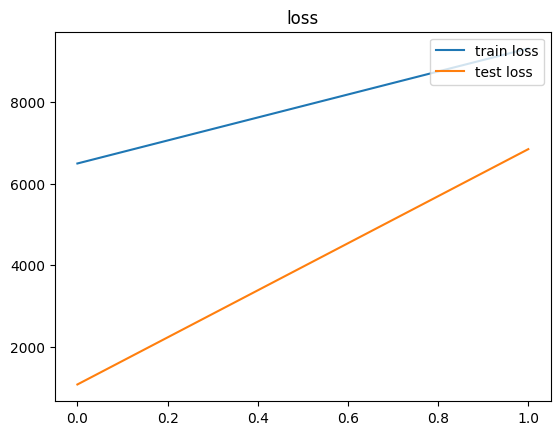

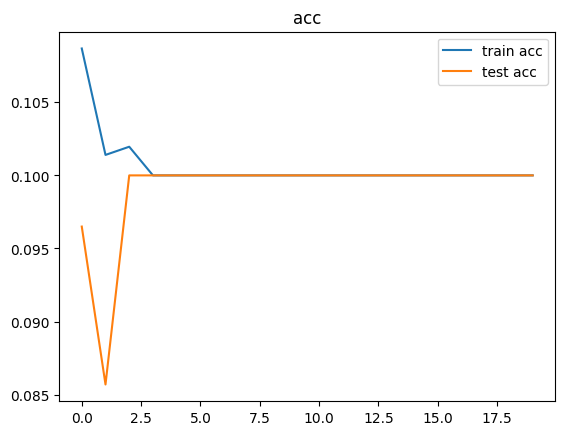

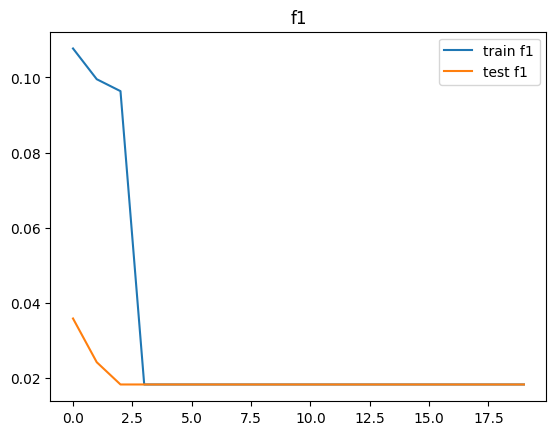

In [57]:
# Plotting
def plot_graphs(logs, metric):
    plt.plot(logs[f'train_{metric}'], label=f'train {metric}')
    plt.plot(logs[f'test_{metric}'], label=f'test {metric}')
    plt.legend(loc='upper right')
    plt.title(metric)
    plt.show()


plot_graphs(logs, 'loss')
plot_graphs(logs, 'acc')
plot_graphs(logs, 'f1')


### Testing 2

In [38]:
# Define RKD Losses
class RKDDistanceLoss(nn.Module):
    def __init__(self):
        super(RKDDistanceLoss, self).__init__()

    def forward(self, student, teacher):
        return F.pairwise_distance(student, teacher).mean()


class RKDAngleLoss(nn.Module):
    def __init__(self):
        super(RKDAngleLoss, self).__init__()

    def forward(self, student, teacher):
        # Normalize vectors
        student = F.normalize(student, dim=1)
        teacher = F.normalize(teacher, dim=1)

        # Get dot product between vectors
        dot = torch.matmul(student, teacher.t())
        return torch.mean(torch.acos(dot) ** 2)


In [26]:
# # Load data
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, 4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# train_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
#     batch_size=128, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10(root='./data', train=False, download=True, transform=transform),
#     batch_size=128, shuffle=False)



In [42]:
# teacher = models.resnet18(pretrained=True, num_classes=10)
# student = models.resnet18(pretrained=False, num_classes=10)
# teacher = models.resnet50(num_classes=10)
# student = models.resnet50(num_classes=10)
# student = models.resnet18(num_classes=10)

teacher = models.resnet18(num_classes=10)
student = models.resnet18(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher.to(device)
student.to(device)


# Training and Evaluation Utilities
optimizer = optim.Adam(student.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_epoch(train_loader, student, teacher, optimizer, criterion):
    student.train()
    teacher.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        student_outputs = student(data)
        with torch.no_grad():
            teacher_outputs = teacher(data)

        loss = criterion(student_outputs, target) + 0.1 * (RKDDistanceLoss()(student_outputs, teacher_outputs) + RKDAngleLoss()(student_outputs, teacher_outputs))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / (batch_idx + 1)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def evaluate(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.cuda(), target.cuda()

            outputs = model(data)
            loss = criterion(outputs, target)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = total_loss / (batch_idx + 1)
    accuracy = 100. * correct / total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1

In [43]:
# Training loop
epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []

for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch(train_loader, student, teacher, optimizer, criterion)
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader, student, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")




Epoch: 1/20
Train Loss: 2.0857, Train Accuracy: 41.7180
Test Loss: 1.3752, Test Accuracy: 55.2400, Test Precision: 0.5558, Test Recall: 0.5524, Test F1: 0.5382
Epoch: 2/20
Train Loss: 1.7819, Train Accuracy: 57.2740
Test Loss: 1.1695, Test Accuracy: 64.2300, Test Precision: 0.6436, Test Recall: 0.6423, Test F1: 0.6366
Epoch: 3/20
Train Loss: 1.6333, Train Accuracy: 64.1300
Test Loss: 1.0331, Test Accuracy: 68.5000, Test Precision: 0.6877, Test Recall: 0.6850, Test F1: 0.6825
Epoch: 4/20
Train Loss: 1.5370, Train Accuracy: 68.2220
Test Loss: 0.9677, Test Accuracy: 71.0500, Test Precision: 0.7209, Test Recall: 0.7105, Test F1: 0.7097
Epoch: 5/20
Train Loss: 1.4715, Train Accuracy: 70.9340
Test Loss: 0.9036, Test Accuracy: 73.2700, Test Precision: 0.7335, Test Recall: 0.7327, Test F1: 0.7309
Epoch: 6/20
Train Loss: 1.4162, Train Accuracy: 73.0320
Test Loss: 0.8539, Test Accuracy: 74.8000, Test Precision: 0.7499, Test Recall: 0.7480, Test F1: 0.7441
Epoch: 7/20
Train Loss: 1.3736, Train Ac

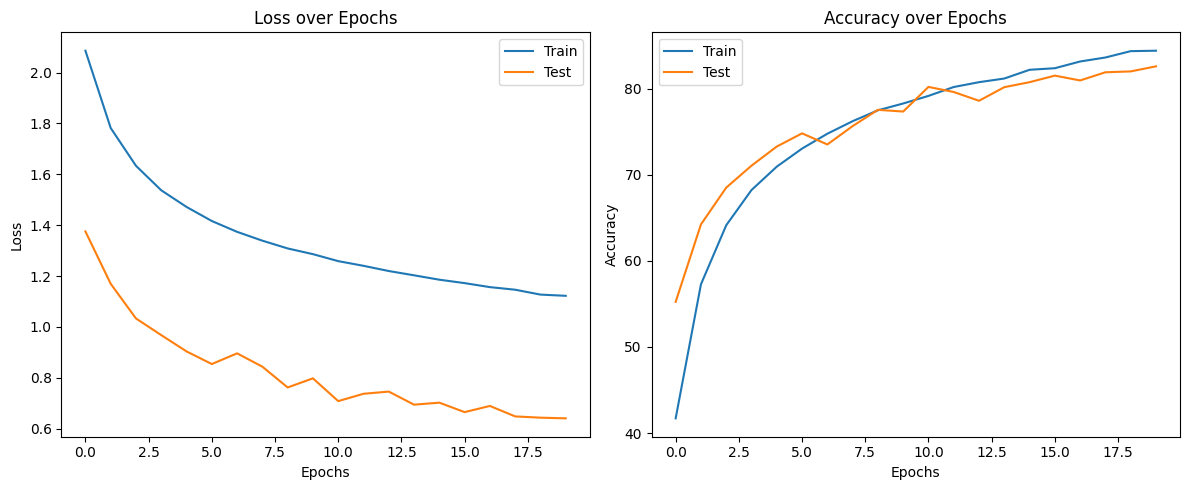

In [44]:
# Plotting the metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
